# Command line for ML.net

[ML.net](https://github.com/dotnet/machinelearning) hides a command line available through DLL Microsoft.ML.Tools.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

We add magic command ``%%maml``.

In [3]:
%load_ext csharpyml

## Maml help

An example on how to get help.

In [4]:
%%maml -q

?

In [5]:
%%maml

? traintest

Help for Command: 'TrainTest'
Summary:
   Trains a predictor using the train file and then scores and evaluates the predictor using the test file.
testFile=<string>                     The test data file (short form test)
trainer=<name>{<options>}             Trainer to use (short form tr)
scorer=<name>{<options>}              Scorer to use
evaluator=<name>{<options>}           Evaluator to use (short form eval)
summaryFilename=<string>              Results summary filename (short form sf)
featureColumn=<string>                Column to use for features Default value:'Features' (short form feat)
labelColumn=<string>                  Column to use for labels Default value:'Label' (short form lab)
weightColumn=<string>                 Column to use for example weight Default value:'Weight' (short form weight)
groupColumn=<string>                  Column to use for grouping Default value:'GroupId' (short form group)
nameColumn=<string>                   Name column name Default value:'Nam

In [6]:
%%maml

? kind=trainer

Available components for kind 'Trainer':
  AveragedPerceptron: Averaged Perceptron
    Aliases: avgper, ap
  BinaryClassificationGamTrainer: Generalized Additive Model for Binary Classification
    Aliases: gam
  BinarySGD: Hogwild SGD (binary)
    Aliases: sgd
  EnsembleRegression: Regression Ensemble (bagging, stacking, etc)
  FastForestClassification: Fast Forest Classification
    Aliases: FastForest, ff, ffc
  FastForestRegression: Fast Forest Regression
    Aliases: ffr
  FastTreeBinaryClassification: FastTree (Boosted Trees) Classification
    Aliases: FastTreeClassification, FastTree, ft, ftc, FastRankBinaryClassification, FastRankBinaryClassificationWrapper, FastRankClassification, fr, btc, frc, fastrank, fastrankwrapper
  FastTreeRanking: FastTree (Boosted Trees) Ranking
    Aliases: ftrank, FastRankRanking, FastRankRankingWrapper, rank, frrank, btrank
  FastTreeRegression: FastTree (Boosted Trees) Regression
    Aliases: ftr, FastRankRegression, FastRankRegressionWrapper, fr

## With Iris

We first split the database into train and test.

In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from pandas import DataFrame

iris = load_iris()
X = iris.data
y = iris.target
df = DataFrame(X, columns=['Slength', 'Swidth', 'Plength', 'Pwidth'])
df["Label"] = y
df = df[["Label"] + ['Slength', 'Swidth', 'Plength', 'Pwidth']]
dftrain, dftest = train_test_split(df)
dftrain.to_csv("iris_data_id_train.txt", sep=',', index=False)
dftest.to_csv("iris_data_id_test.txt", sep=',', index=False)

And we run the [command line of maml](http://www.xavierdupre.fr/app/machinelearningext/helpsphinx/commandline.html) to train and test a multi-logistic regression.

In [8]:
%%maml

traintest
data=iris_data_id_train.txt
test=iris_data_id_test.txt
loader=text{col=Label:U4[0-2]:0 col=Slength:R4:1 col=Swidth:R4:2 col=Plength:R4:3 col=Pwidth:R4:4 sep=, header=+}
xf=Concat{col=Features:Slength,Swidth}
tr=mlr
out=model.zip
dout=prediction.txt

maml.exe TrainTest test=iris_data_id_test.txt tr=mlr dout=prediction.txt loader=text{col=Label:U4[0-2]:0 col=Slength:R4:1 col=Swidth:R4:2 col=Plength:R4:3 col=Pwidth:R4:4 sep=, header=+} data=iris_data_id_train.txt out=model.zip xf=Concat{col=Features:Slength,Swidth}
Finished.
Elapsed 00:00:00.0170564.
Finished.
Elapsed 00:00:00.0705119.
Finished.
Elapsed 00:00:00.0674517.
Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
Finished.
Elapsed 00:00:00.0259844.
Finished.
Elapsed 00:00:00.0272845.
Finished.
Elapsed 00:00:00.0521668.
Finished.
Elapsed 00:00:00.0437875.
Finished.
Elapsed 00:00:00.0968136.
Finished.
Elapsed 00:00:00.0978194.
Finished.
Elapsed 00:00:00.1052928.
Finished.
Elapsed 00:00:00.0988343.
Finished.
Elapsed 00:00:00.0898111.
[1] 'Normalize' started.
Finished.
Elapsed 00:00:00.0781149.
Finished.
Elapsed 00:00:00.1851906.
Finished.
Elapsed 00:00:00.0083682.
Finished.
Elapsed 00:00:00.0083488.
Finished.
Elapsed 00

Let's look at the prediction saved in ``predictions.txt``.

In [9]:
from pandas import read_csv
pred = read_csv("prediction.txt", sep="\t")
pred.head()

,Instance,Label,Assigned,Log-loss,#1 Score,#2 Score,#3 Score,#1 Class,#2 Class,#3 Class
0,0,0,0,0.800175,0.449250,0.305061,0.245689,0,1,2
1,1,1,2,1.105172,0.396012,0.331154,0.272834,2,1,0
2,2,1,2,1.217020,0.382617,0.321272,0.296111,2,0,1
3,3,1,1,1.056950,0.347514,0.344978,0.307508,1,0,2
4,4,2,2,0.870286,0.418832,0.320862,0.260306,2,1,0


## With a C# pipeline

The class *CSPipeline* wraps class [DataFrame](http://www.xavierdupre.fr/app/machinelearningext/helpsphinx/dataframe.html#dataframe) (C#). Let's rewrite the previous script.

In [10]:
iris = load_iris()
X = iris.data
y = iris.target
df = DataFrame(X, columns=['Slength', 'Swidth', 'Plength', 'Pwidth'])
df["Label"] = y
df = df[["Label"] + ['Slength', 'Swidth', 'Plength', 'Pwidth']]
dftrain, dftest = train_test_split(df)

Let's then create a pipeline and tell that that we would like information about the training (``verbose=2``).

In [11]:
from csharpyml.binaries import CSPipeline
pipe = CSPipeline(["Concat{col=Features:Slength,Swidth}"], "mlr", verbose=2)
pipe

In [12]:
try:
    pipe.fit(dftrain, "Features", "Label")
except Exception as e:
    print(e)

Training feature column 'Features' must be a known-size vector of R4, but has type: Vec<R8, 2>.
Nom du paramètre : data
   à Microsoft.ML.Runtime.Training.TrainerUtils.CheckFeatureFloatVector(RoleMappedData data)
   à Microsoft.ML.Runtime.Training.TrainerUtils.CheckFeatureFloatVector(RoleMappedData data, Int32& length)
   à Microsoft.ML.Runtime.Learners.LbfgsTrainerBase`3.TrainModelCore(TrainContext context)
   à Microsoft.ML.Runtime.Training.TrainerEstimatorBase`2.Microsoft.ML.Runtime.ITrainer.Train(TrainContext context)
   à Scikit.ML.PipelineHelper.ExtendedTrainer.Train(IHostEnvironment env, IChannel ch, RoleMappedData data, RoleMappedData validData, ICalibratorTrainer calibrator, Int32 maxCalibrationExamples, Nullable`1 cacheData, IPredictor inputPredictor)
   à Scikit.ML.ScikitAPI.ScikitPipeline.Train(IDataView data, String feature, String label, String weight, String groupId)


The pipeline only allows single float. Columns needs to be converted.

In [13]:
import numpy
df = df.astype(numpy.float32)
dftrain, dftest = train_test_split(df)

In [14]:
pipe.fit(dftrain, "Features", "Label")

Less display. One reason is the pipeline only did the training.

In [15]:
print(pipe.StdOut)

Finished.
Elapsed 00:00:00.0112853.
Finished.
Elapsed 00:00:00.0071680.
Finished.
Elapsed 00:00:00.0487902.
Finished.
Elapsed 00:00:00.0630144.
Finished.
Elapsed 00:00:00.0528652.
Finished.
Elapsed 00:00:00.0560415.
Finished.
Elapsed 00:00:00.0029538.
Finished.
Elapsed 00:00:00.0673147.
Finished.
Elapsed 00:00:00.0604054.
Finished.
Elapsed 00:00:00.0079656.
Finished.
Elapsed 00:00:00.0175044.
Finished.
Elapsed 00:00:00.0097098.
Finished.
Elapsed 00:00:00.0100112.
Finished.
Elapsed 00:00:00.0057090.
Finished.
Elapsed 00:00:00.0032339.
Finished.
Elapsed 00:00:00.0061779.
LBFGS multi-threading will attempt to load dataset into memory. In case of out-of-memory issues, add 'numThreads=1' to the trainer arguments and 'cache=-' to the command line arguments to turn off multi-threading.
Finished.
Elapsed 00:00:00.0008580.
Beginning optimization
num vars: 9
improvement criterion: Mean Improvement
Finished.
Elapsed 00:00:00.0174507.
L1 regularization selected 8 of 9 weights.
Finished.
Elapsed 00

In [16]:
pred = pipe.predict(dftest)
pred.head()

,Label,Slength,Swidth,Plength,Pwidth,Features.0,Features.1,PredictedLabel,Score.0,Score.1,Score.2
0,0.0,4.8,3.4,1.9,0.2,4.8,3.4,1,0.871073,0.107746,0.021181
1,0.0,5.0,3.2,1.2,0.2,5.0,3.2,1,0.692325,0.251365,0.056310
2,0.0,4.3,3.0,1.1,0.1,4.3,3.0,1,0.827272,0.162150,0.010578
3,0.0,5.1,3.4,1.5,0.2,5.1,3.4,1,0.778279,0.169280,0.052440
4,0.0,5.5,3.5,1.3,0.2,5.5,3.5,1,0.655036,0.213037,0.131927


In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(dftest["Label"], pred["PredictedLabel"] - 1)

array([[18,  1,  0],
       [ 0,  5,  4],
       [ 0,  4,  6]], dtype=int64)

## Another classifier

[ML.net](https://github.com/dotnet/machinelearning) implements many classifiers for [multi-class classification](http://www.xavierdupre.fr/app/csharpyml/helpsphinx/components/multiclassclassifiertrainer.html).

In [18]:
from csharpyml.binaries import CSPipeline
pipe = CSPipeline(["Concat{col=Features:Slength,Swidth}"], "SDCAMC", verbose=2)
pipe.fit(dftrain, "Features", "Label")

In [19]:
print(pipe.StdOut)

Finished.
Elapsed 00:00:00.0003796.
Finished.
Elapsed 00:00:00.0009493.
Finished.
Elapsed 00:00:00.0011792.
Finished.
Elapsed 00:00:00.0012638.
Finished.
Elapsed 00:00:00.0013605.
Finished.
Elapsed 00:00:00.0006648.
Finished.
Elapsed 00:00:00.0001244.
Finished.
Elapsed 00:00:00.0000715.
Using 2 threads to train.
Automatically choosing a check frequency of 2.
Finished.
Elapsed 00:00:00.0015284.
Auto-tuning parameters: maxIterations = 13392.
Auto-tuning parameters: L2 = 2.666837E-05.
Auto-tuning parameters: L1Threshold (L1/L2) = 0.
Finished.
Elapsed 00:00:00.0005811.
Finished.
Elapsed 00:00:00.0121473.
Finished.
Elapsed 00:00:00.0138291.
Finished.
Elapsed 00:00:00.0017844.
Finished.
Elapsed 00:00:00.0002401.
Finished.
Elapsed 00:00:00.0002540.
Finished.
Elapsed 00:00:00.0000873.
Finished.
Elapsed 00:00:00.0002149.
Finished.
Elapsed 00:00:00.0002014.
Finished.
Elapsed 00:00:00.0002196.
Finished.
Elapsed 00:00:00.0003314.
Finished.
Elapsed 00:00:00.0003200.
Finished.
Elapsed 00:00:00.00026

In [20]:
pred2 = pipe.predict(dftest)
pred2.head()

,Label,Slength,Swidth,Plength,Pwidth,Features.0,Features.1,PredictedLabel,Score.0,Score.1,Score.2
0,0.0,4.8,3.4,1.9,0.2,4.8,3.4,1,0.999958,0.000040,0.000002
1,0.0,5.0,3.2,1.2,0.2,5.0,3.2,1,0.990728,0.008712,0.000561
2,0.0,4.3,3.0,1.1,0.1,4.3,3.0,1,0.999722,0.000274,0.000004
3,0.0,5.1,3.4,1.5,0.2,5.1,3.4,1,0.999167,0.000770,0.000062
4,0.0,5.5,3.5,1.3,0.2,5.5,3.5,1,0.991518,0.007074,0.001408


In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(dftest["Label"], pred2["PredictedLabel"] - 1)

array([[18,  1,  0],
       [ 0,  3,  6],
       [ 0,  4,  6]], dtype=int64)

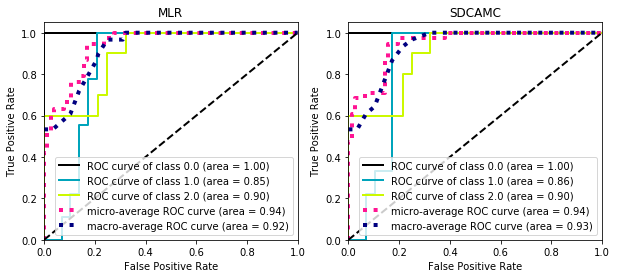

In [22]:
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,4))
plot_roc(dftest["Label"], pred[["Score.0", "Score.1", "Score.2"]], ax=ax[0])
plot_roc(dftest["Label"], pred2[["Score.0", "Score.1", "Score.2"]], ax=ax[1])
ax[0].set_title("MLR")
ax[1].set_title("SDCAMC");